In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.stats import spearmanr
import numpy as np

GBIF.org (04 November 2024) GBIF Occurrence Download  https://doi.org/10.15468/dl.s8gc9c

For Question3 we need to add external datasets:

1. Here is a list of useful Datasets:

- USGS EarthExplorer
https://earthexplorer.usgs.gov/

- WorldClim
    https://www.worldclim.org/
    => Historical climate data

- ESA WorldCover
    - https://modis.gsfc.nasa.gov/data/dataprod/mod12.php => https://lpdaac.usgs.gov/products/mcd12q1v061/

    - https://esa-worldcover.org/en


- Dynamic World
https://www.dynamicworld.app/

- https://www.un-spider.org/links-and-resources/data-sources/land-cover-kenya-africover-fao


- HydroSHEDS
https://www.hydrosheds.org/

after careful consideration in datasets, their quality and size we chose:

Statistical Analysis: we examine correlations or conduct regression analyses to assess how precipitation and elevation affect bird abundance.

Visualization: we create maps and graphs to visualize the relationships between bird abundance and the environmental factors.

Loading bird occurrence data...


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56040/2727319792.py:21: DtypeWarning: Columns (170) have mixed types. Specify dtype option on import or set low_memory=False.
  occurrence_data = pd.read_csv(occurrence_path, delimiter='\t')


Bird occurrence data loaded and converted to GeoDataFrame.
Loading rivers data...
Rivers data loaded.
Loading elevation data...
Elevation Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333333333333, 0.0, -180.0,
       0.0, -0.008333333333333333, 90.0)}
Elevation Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)


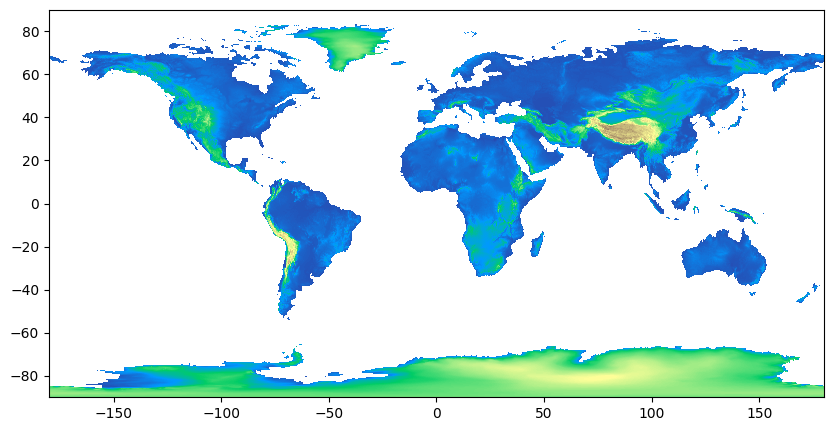

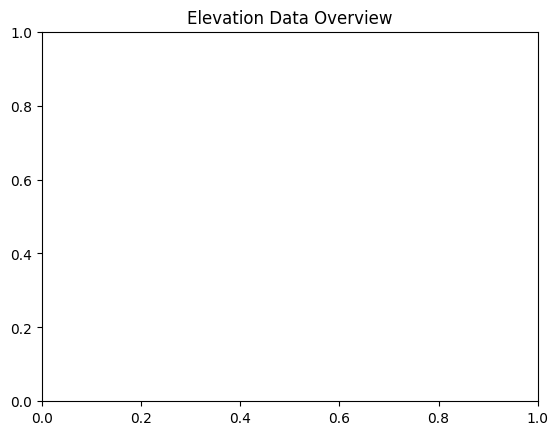

Loading sample precipitation data (January)...
Precipitation Metadata (January): {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333333333333, 0.0, -180.0,
       0.0, -0.008333333333333333, 90.0)}
Precipitation Bounds (January): BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)


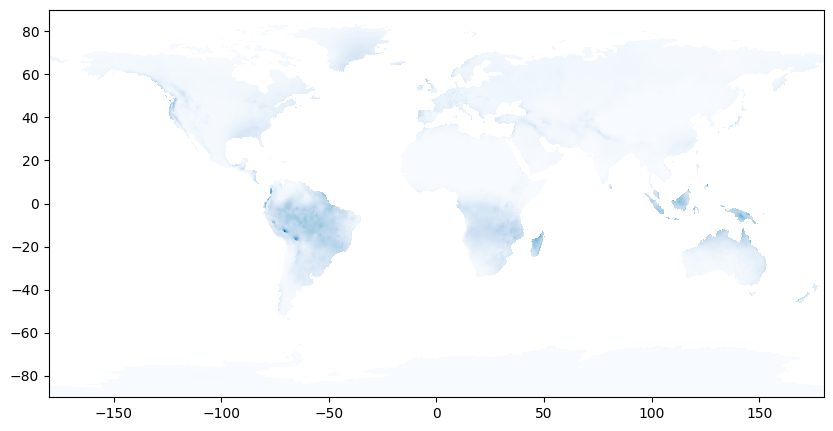

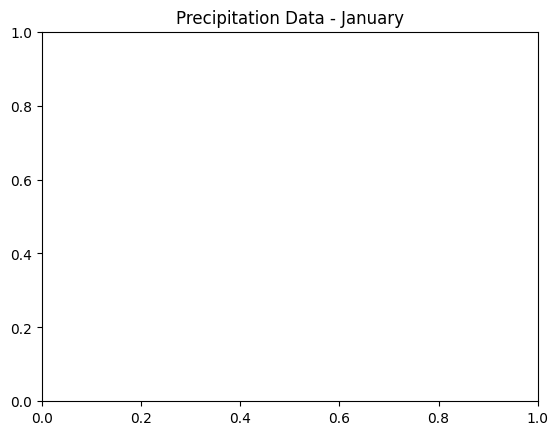

Extracting elevation values for each bird observation point...
New elevation values extracted and added to GeoDataFrame.
Extracting monthly precipitation values for each point and calculating the average...
Processing precipitation data for month 1...
Processing precipitation data for month 2...
Processing precipitation data for month 3...
Processing precipitation data for month 4...
Processing precipitation data for month 5...
Processing precipitation data for month 6...
Processing precipitation data for month 7...
Processing precipitation data for month 8...
Processing precipitation data for month 9...
Processing precipitation data for month 10...
Processing precipitation data for month 11...
Processing precipitation data for month 12...
Average precipitation calculated and added to GeoDataFrame.
Calculating correlations between environmental factors and bird abundance...
Spearman Correlation between Elevation and Bird Abundance: nan
Spearman Correlation between Average Precipitation

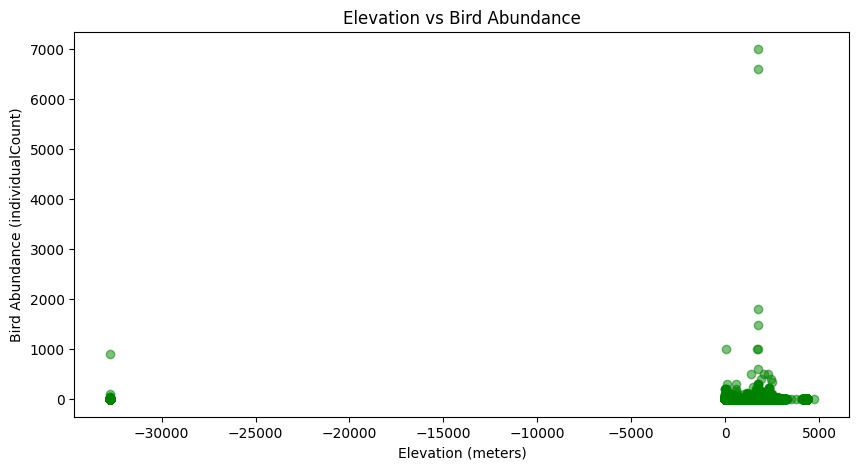

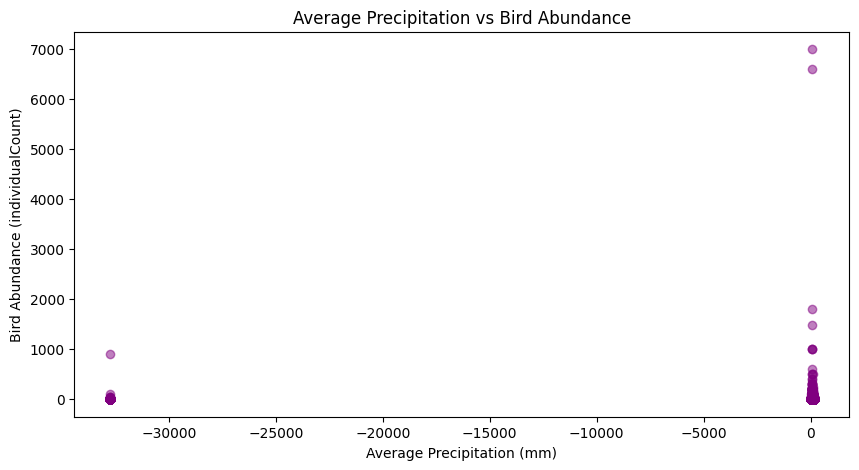

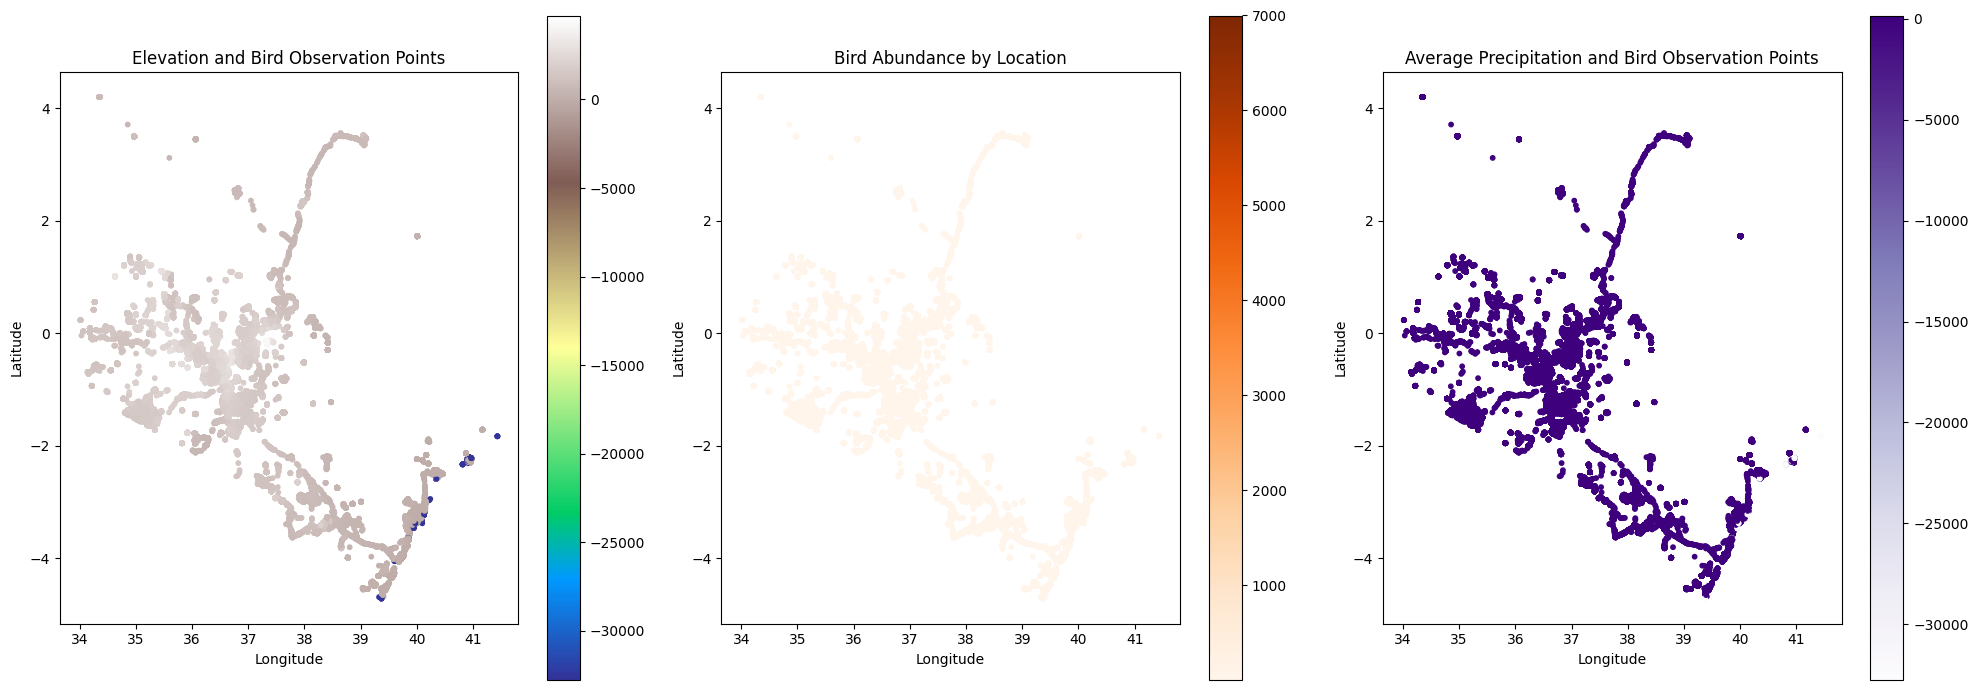

In [ ]:
# Paths for data files
occurrence_path = '/Users/mina/Desktop/MADS/3rd_semester/WorkshopI/geospatial-data-analysis/data/GBIT_annotated_archive/DARWIN_CORE_ARCHIVE/0020723-241024112534372/occurrence.txt'
rivers_path = '/Users/mina/Desktop/MADS/3rd_semester/WorkshopI/geospatial-data-analysis/data/Extra/HydroRIVERS_v10_af_shp/HydroRIVERS_v10_af_shp'
elevation_path = '/Users/mina/Desktop/MADS/3rd_semester/WorkshopI/geospatial-data-analysis/data/Extra/wc2.1_30s_elev.tif'
monthly_precip_files = [
    f'/Users/mina/Desktop/MADS/3rd_semester/WorkshopI/geospatial-data-analysis/data/Extra/wc2.1_30s_prec/wc2.1_30s_prec_{str(i).zfill(2)}.tif' for i in range(1, 13)
]

# Step 1: Load bird occurrence data (filter for Kenya and ensure 'individualCount' and coordinates exist)
print("Loading bird occurrence data...")
occurrence_data = pd.read_csv(occurrence_path, delimiter='\t')
occurrence_data = occurrence_data[occurrence_data['countryCode'] == 'KE']  # Filter for Kenya

# Convert occurrence data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(occurrence_data['decimalLongitude'], occurrence_data['decimalLatitude'])]
occurrence_gdf = gpd.GeoDataFrame(occurrence_data, geometry=geometry, crs="EPSG:4326")
print("Bird occurrence data loaded and converted to GeoDataFrame.")

# Step 2: Load rivers data (HydroRIVERS)
print("Loading rivers data...")
rivers_gdf = gpd.read_file(rivers_path)
print("Rivers data loaded.")

# Step 3: Load and inspect elevation data (WorldClim)
print("Loading elevation data...")
with rasterio.open(elevation_path) as elev_raster:
    print("Elevation Metadata:", elev_raster.meta)
    print("Elevation Bounds:", elev_raster.bounds)
    
    # Show elevation data overview
    plt.figure(figsize=(10, 6))
    show(elev_raster, cmap='terrain')
    plt.title("Elevation Data Overview")
    plt.show()

# Step 4: Load and inspect one sample monthly precipitation file (e.g., January)
print("Loading sample precipitation data (January)...")
with rasterio.open(monthly_precip_files[0]) as precip_raster:
    print("Precipitation Metadata (January):", precip_raster.meta)
    print("Precipitation Bounds (January):", precip_raster.bounds)
    
    # Show precipitation data overview
    plt.figure(figsize=(10, 6))
    show(precip_raster, cmap='Blues')
    plt.title("Precipitation Data - January")
    plt.show()

# Step 5: Extract elevation values for each bird observation point
print("Extracting elevation values for each bird observation point...")

# Drop the empty elevation column if it exists and is empty
if 'elevation' in occurrence_gdf.columns and occurrence_gdf['elevation'].isnull().all():
    occurrence_gdf = occurrence_gdf.drop(columns=['elevation'])

# Sample coordinates and add new elevation values
coordinates = [(x, y) for x, y in zip(occurrence_gdf['decimalLongitude'], occurrence_gdf['decimalLatitude'])]
with rasterio.open(elevation_path) as elev_raster:
    elevation_values = [val[0] for val in elev_raster.sample(coordinates)]
occurrence_gdf['elevation'] = elevation_values  # Adding the new elevation data
print("New elevation values extracted and added to GeoDataFrame.")

# Step 6: Extract and calculate average precipitation for each bird observation point
print("Extracting monthly precipitation values for each point and calculating the average...")

# Drop the empty average_precipitation column if it exists and is empty
if 'average_precipitation' in occurrence_gdf.columns and occurrence_gdf['average_precipitation'].isnull().all():
    occurrence_gdf = occurrence_gdf.drop(columns=['average_precipitation'])

# Extract monthly precipitation values
monthly_precip_values = []
for i, file in enumerate(monthly_precip_files, 1):
    print(f"Processing precipitation data for month {i}...")
    with rasterio.open(file) as src:
        monthly_values = [val[0] for val in src.sample(coordinates)]
        monthly_precip_values.append(monthly_values)

# Convert monthly precipitation values to a NumPy array and calculate the average across 12 months
monthly_precip_array = np.array(monthly_precip_values)
average_precipitation = monthly_precip_array.mean(axis=0)
occurrence_gdf['average_precipitation'] = average_precipitation
print("Average precipitation calculated and added to GeoDataFrame.")

# Step 7: Calculate Spearman correlation between bird abundance and environmental factors
print("Calculating correlations between environmental factors and bird abundance...")
correlation_elevation, _ = spearmanr(occurrence_gdf['elevation'], occurrence_gdf['individualCount'])
correlation_precipitation, _ = spearmanr(occurrence_gdf['average_precipitation'], occurrence_gdf['individualCount'])

print(f"Spearman Correlation between Elevation and Bird Abundance: {correlation_elevation:.2f}")
print(f"Spearman Correlation between Average Precipitation and Bird Abundance: {correlation_precipitation:.2f}")

# Step 8: Visualize the relationships with scatter plots
# Scatter plot for Elevation vs Bird Abundance
plt.figure(figsize=(10, 5))
plt.scatter(occurrence_gdf['elevation'], occurrence_gdf['individualCount'], alpha=0.5, color='green')
plt.title("Elevation vs Bird Abundance")
plt.xlabel("Elevation (meters)")
plt.ylabel("Bird Abundance (individualCount)")
plt.show()

# Scatter plot for Average Precipitation vs Bird Abundance
plt.figure(figsize=(10, 5))
plt.scatter(occurrence_gdf['average_precipitation'], occurrence_gdf['individualCount'], alpha=0.5, color='purple')
plt.title("Average Precipitation vs Bird Abundance")
plt.xlabel("Average Precipitation (mm)")
plt.ylabel("Bird Abundance (individualCount)")
plt.show()

# Step 9: Map bird abundance with elevation, average precipitation
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

# Map elevation
occurrence_gdf.plot(column='elevation', cmap='terrain', ax=ax[0], legend=True, markersize=10)
ax[0].set_title("Elevation and Bird Observation Points")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

# Map bird abundance
occurrence_gdf.plot(column='individualCount', cmap='Oranges', ax=ax[1], legend=True, markersize=10)
ax[1].set_title("Bird Abundance by Location")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

# Map average precipitation
occurrence_gdf.plot(column='average_precipitation', cmap='Purples', ax=ax[2], legend=True, markersize=10)
ax[2].set_title("Average Precipitation and Bird Observation Points")
ax[2].set_xlabel("Longitude")
ax[2].set_ylabel("Latitude")

plt.tight_layout()
plt.show()


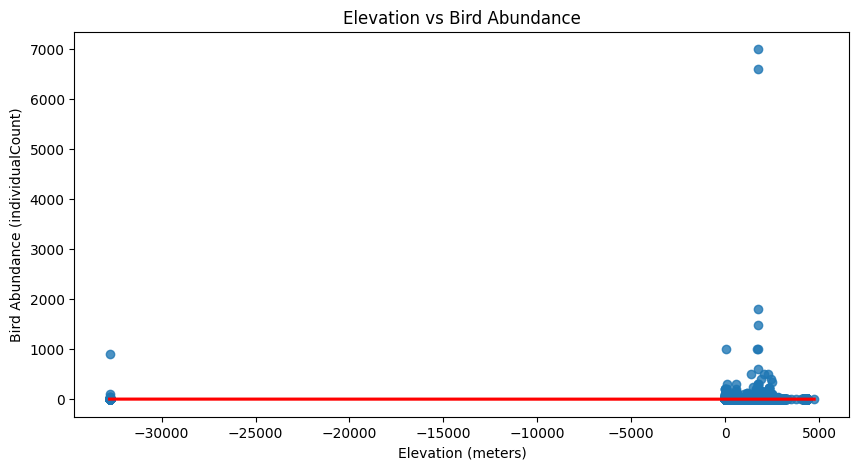

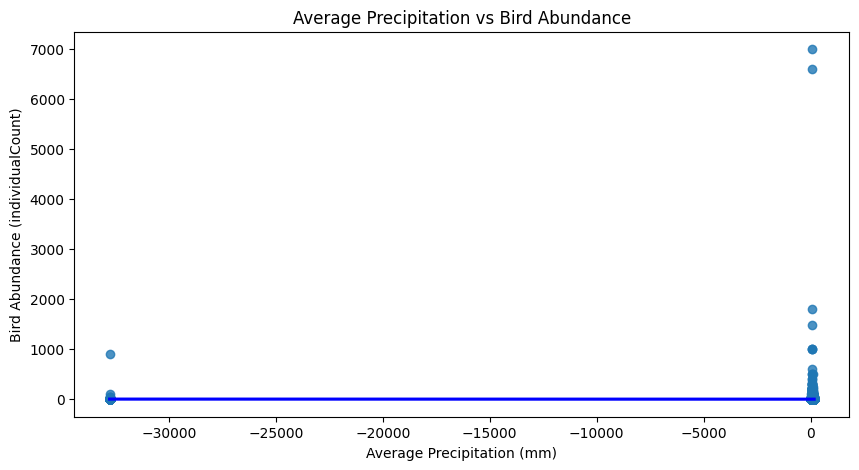

In [12]:
import seaborn as sns

# Scatter plot for Elevation vs Bird Abundance with trendline
plt.figure(figsize=(10, 5))
sns.regplot(x=occurrence_gdf['elevation'], y=occurrence_gdf['individualCount'], line_kws={"color": "red"})
plt.title("Elevation vs Bird Abundance")
plt.xlabel("Elevation (meters)")
plt.ylabel("Bird Abundance (individualCount)")
plt.show()

# Scatter plot for Average Precipitation vs Bird Abundance with trendline
plt.figure(figsize=(10, 5))
sns.regplot(x=occurrence_gdf['average_precipitation'], y=occurrence_gdf['individualCount'], line_kws={"color": "blue"})
plt.title("Average Precipitation vs Bird Abundance")
plt.xlabel("Average Precipitation (mm)")
plt.ylabel("Bird Abundance (individualCount)")
plt.show()


In [13]:
from scipy.stats import kendalltau

# Calculate Kendall's Tau correlation
kendall_corr_elevation, _ = kendalltau(occurrence_gdf['elevation'], occurrence_gdf['individualCount'])
kendall_corr_precipitation, _ = kendalltau(occurrence_gdf['average_precipitation'], occurrence_gdf['individualCount'])

print(f"Kendall's Tau between Elevation and Bird Abundance: {kendall_corr_elevation:.2f}")
print(f"Kendall's Tau between Average Precipitation and Bird Abundance: {kendall_corr_precipitation:.2f}")


Kendall's Tau between Elevation and Bird Abundance: nan
Kendall's Tau between Average Precipitation and Bird Abundance: nan


/usr/local/lib/python3.10/site-packages/pandas/core/reshape/tile.py:404: RuntimeWarning: overflow encountered in scalar subtract
  adj = (mx - mn) * 0.001  # 0.1% of the range
/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56040/555638359.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elevation_bins = occurrence_gdf.groupby('elevation_bin')['individualCount'].mean()


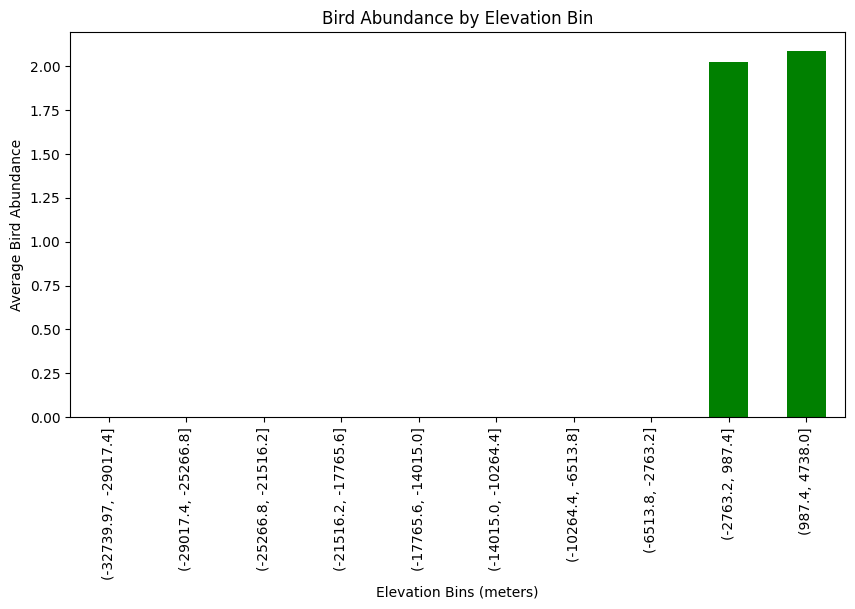

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56040/555638359.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precipitation_bins = occurrence_gdf.groupby('precipitation_bin')['individualCount'].mean()


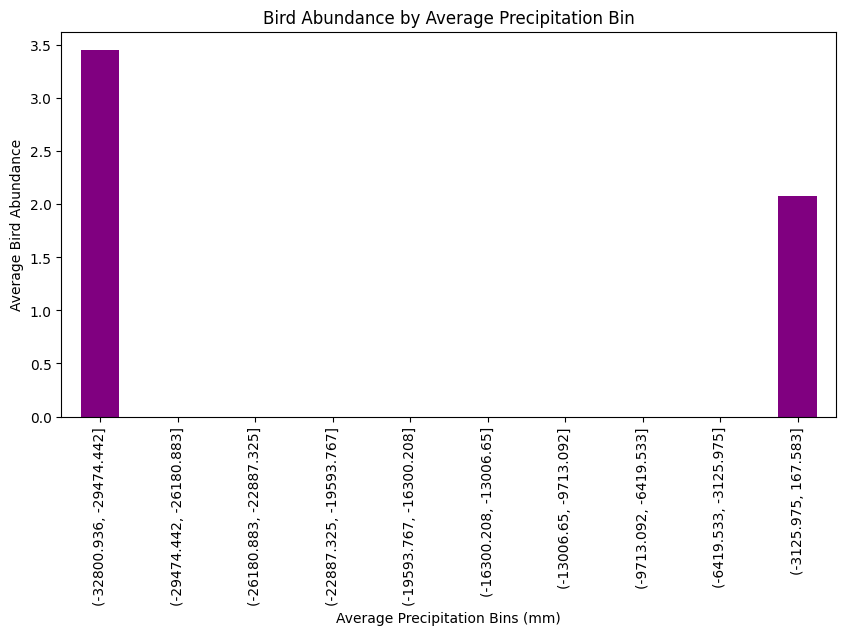

In [14]:
# Binned analysis for elevation
occurrence_gdf['elevation_bin'] = pd.cut(occurrence_gdf['elevation'], bins=10)  # 10 bins for elevation
elevation_bins = occurrence_gdf.groupby('elevation_bin')['individualCount'].mean()

# Plot bird abundance by elevation bin
plt.figure(figsize=(10, 5))
elevation_bins.plot(kind='bar', color='green')
plt.title("Bird Abundance by Elevation Bin")
plt.xlabel("Elevation Bins (meters)")
plt.ylabel("Average Bird Abundance")
plt.show()

# Binned analysis for average precipitation
occurrence_gdf['precipitation_bin'] = pd.cut(occurrence_gdf['average_precipitation'], bins=10)  # 10 bins for precipitation
precipitation_bins = occurrence_gdf.groupby('precipitation_bin')['individualCount'].mean()

# Plot bird abundance by precipitation bin
plt.figure(figsize=(10, 5))
precipitation_bins.plot(kind='bar', color='purple')
plt.title("Bird Abundance by Average Precipitation Bin")
plt.xlabel("Average Precipitation Bins (mm)")
plt.ylabel("Average Bird Abundance")
plt.show()


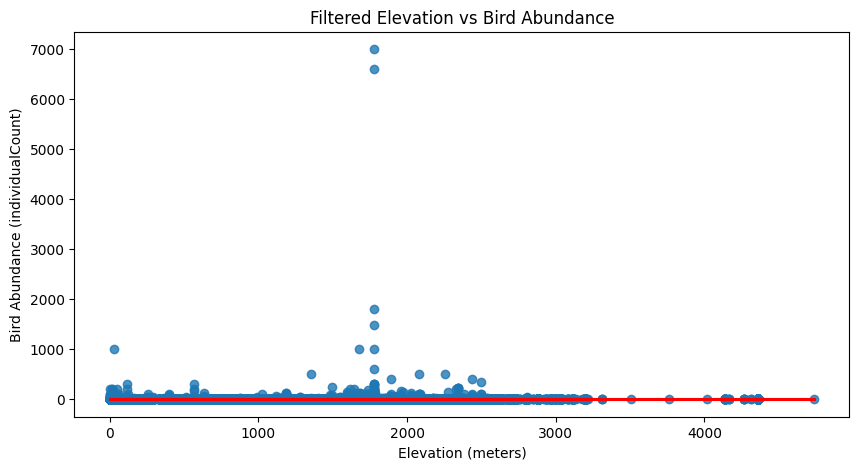

In [16]:
# Filter out extreme elevation values outside of a plausible range
valid_elevation_gdf = occurrence_gdf[(occurrence_gdf['elevation'] >= -500) & (occurrence_gdf['elevation'] <= 9000)]

# Scatter plot for Elevation vs Bird Abundance with trendline after filtering
plt.figure(figsize=(10, 5))
sns.regplot(x=valid_elevation_gdf['elevation'], y=valid_elevation_gdf['individualCount'], line_kws={"color": "red"})
plt.title("Filtered Elevation vs Bird Abundance")
plt.xlabel("Elevation (meters)")
plt.ylabel("Bird Abundance (individualCount)")
plt.show()


/usr/local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56040/3162813480.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precipitation_bins = valid_precipitation_gdf.groupby('precipitation_bin')['individualCount'].mean()


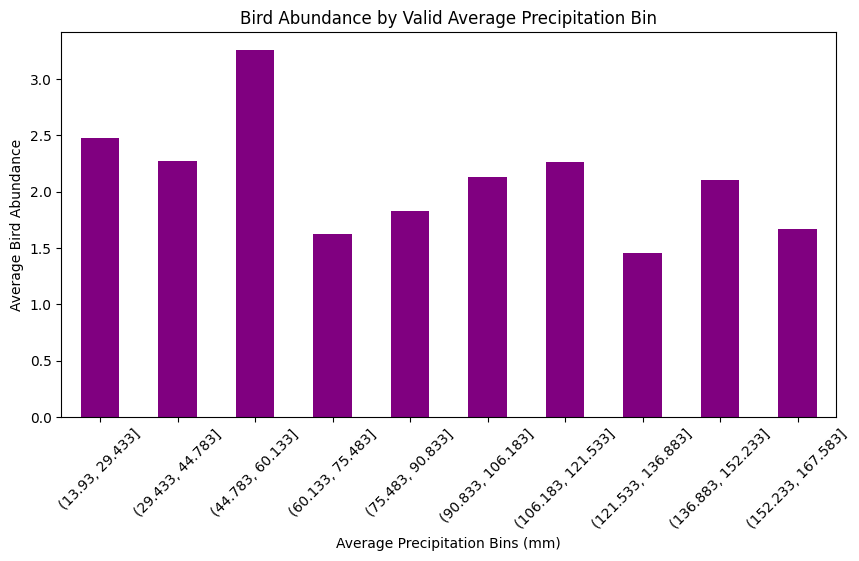

In [17]:
# Filter out invalid precipitation values (e.g., negative values)
valid_precipitation_gdf = occurrence_gdf[occurrence_gdf['average_precipitation'] >= 0]

# Binned analysis for valid average precipitation
valid_precipitation_gdf['precipitation_bin'] = pd.cut(valid_precipitation_gdf['average_precipitation'], bins=10)  # 10 bins for precipitation
precipitation_bins = valid_precipitation_gdf.groupby('precipitation_bin')['individualCount'].mean()

# Plot bird abundance by valid precipitation bin
plt.figure(figsize=(10, 5))
precipitation_bins.plot(kind='bar', color='purple')
plt.title("Bird Abundance by Valid Average Precipitation Bin")
plt.xlabel("Average Precipitation Bins (mm)")
plt.ylabel("Average Bird Abundance")
plt.xticks(rotation=45)
plt.show()


Loading bird occurrence data...


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56040/530822856.py:21: DtypeWarning: Columns (170) have mixed types. Specify dtype option on import or set low_memory=False.
  occurrence_data = pd.read_csv(occurrence_path, delimiter='\t')


Bird occurrence data loaded and converted to GeoDataFrame.
Extracting elevation values for each bird observation point...
Elevation values extracted and added to GeoDataFrame.
Extracting monthly precipitation values for each point and calculating the average...
Processing precipitation data for month 1...
Processing precipitation data for month 2...
Processing precipitation data for month 3...
Processing precipitation data for month 4...
Processing precipitation data for month 5...
Processing precipitation data for month 6...
Processing precipitation data for month 7...
Processing precipitation data for month 8...
Processing precipitation data for month 9...
Processing precipitation data for month 10...
Processing precipitation data for month 11...
Processing precipitation data for month 12...
Average precipitation calculated and added to GeoDataFrame.
Outliers removed from elevation and precipitation columns.
Applying quantile-based binning for elevation and precipitation...


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56040/530822856.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elevation_bins = occurrence_gdf.groupby('elevation_bin')['individualCount'].mean()
/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56040/530822856.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precipitation_bins = occurrence_gdf.groupby('precipitation_bin')['individualCount'].mean()


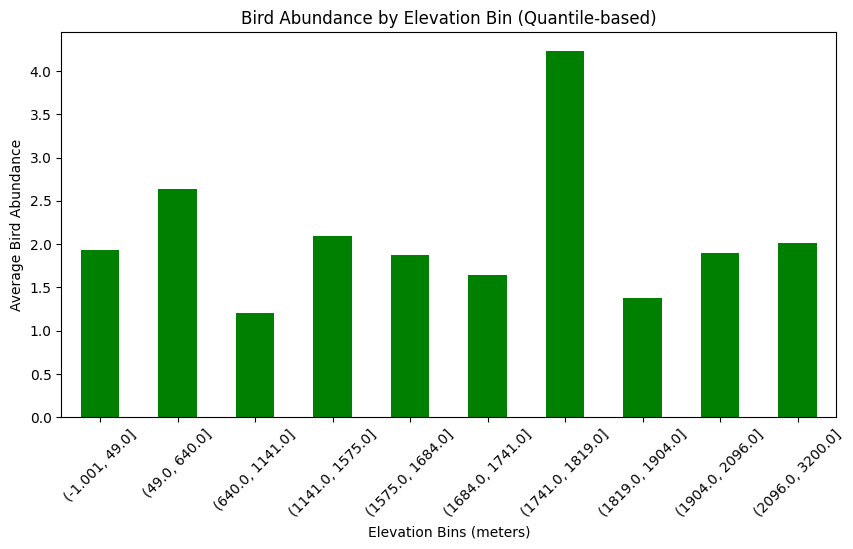

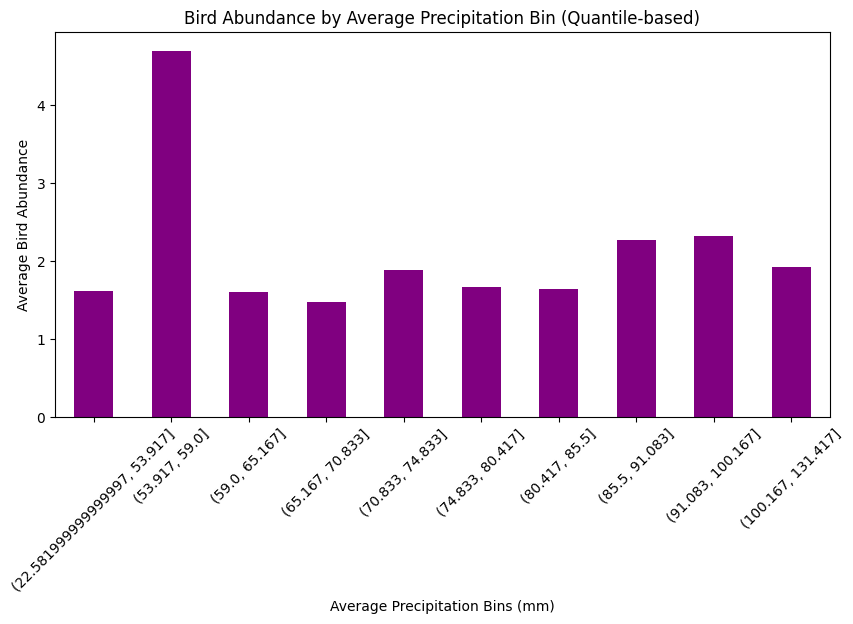

Calculating correlations between environmental factors and bird abundance...
Kendall's Tau between Elevation and Bird Abundance: nan
Kendall's Tau between Average Precipitation and Bird Abundance: nan


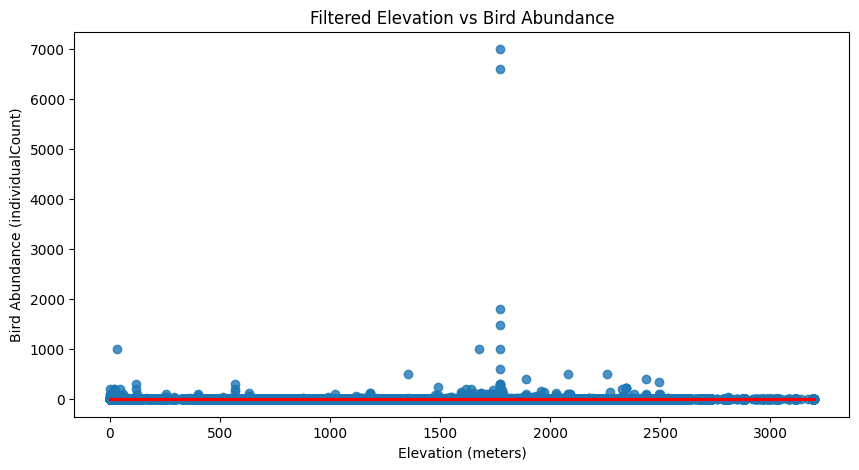

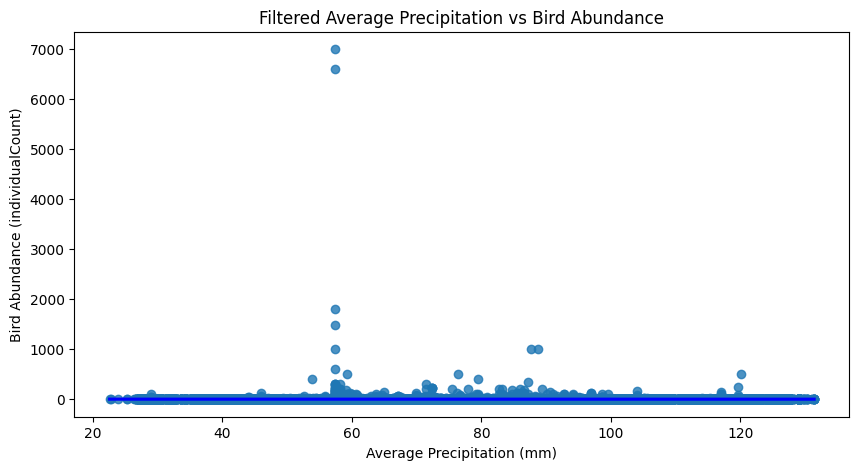

In [20]:
# Import required libraries
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from rasterio.plot import show
from scipy.stats import spearmanr, kendalltau

# Paths for data files
occurrence_path = '/Users/mina/Desktop/MADS/3rd_semester/WorkshopI/geospatial-data-analysis/data/GBIT_annotated_archive/DARWIN_CORE_ARCHIVE/0020723-241024112534372/occurrence.txt'
elevation_path = '/Users/mina/Desktop/MADS/3rd_semester/WorkshopI/geospatial-data-analysis/data/Extra/wc2.1_30s_elev.tif'
monthly_precip_files = [
    f'/Users/mina/Desktop/MADS/3rd_semester/WorkshopI/geospatial-data-analysis/data/Extra/wc2.1_30s_prec/wc2.1_30s_prec_{str(i).zfill(2)}.tif' for i in range(1, 13)
]

# Step 1: Load bird occurrence data (Filter for Kenya but do not drop NaNs yet)
print("Loading bird occurrence data...")
occurrence_data = pd.read_csv(occurrence_path, delimiter='\t')
occurrence_data = occurrence_data[occurrence_data['countryCode'] == 'KE']  # Filter for Kenya

# Convert occurrence data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(occurrence_data['decimalLongitude'], occurrence_data['decimalLatitude'])]
occurrence_gdf = gpd.GeoDataFrame(occurrence_data, geometry=geometry, crs="EPSG:4326")
print("Bird occurrence data loaded and converted to GeoDataFrame.")

# Step 2: Extract elevation values for each bird observation point (don't drop rows yet)
print("Extracting elevation values for each bird observation point...")
coordinates = [(x, y) for x, y in zip(occurrence_gdf['decimalLongitude'], occurrence_gdf['decimalLatitude'])]
with rasterio.open(elevation_path) as elev_raster:
    elevation_values = [val[0] if val else np.nan for val in elev_raster.sample(coordinates)]
occurrence_gdf['elevation'] = elevation_values
print("Elevation values extracted and added to GeoDataFrame.")

# Step 3: Extract and calculate average precipitation for each bird observation point
print("Extracting monthly precipitation values for each point and calculating the average...")
monthly_precip_values = []

for i, file in enumerate(monthly_precip_files, 1):
    print(f"Processing precipitation data for month {i}...")
    with rasterio.open(file) as src:
        # Sample precipitation values
        monthly_values = [val[0] if val else np.nan for val in src.sample(coordinates)]
        monthly_precip_values.append(monthly_values)

# Convert to a NumPy array and calculate average, handling NaNs by using np.nanmean
monthly_precip_array = np.array(monthly_precip_values)
average_precipitation = np.nanmean(monthly_precip_array, axis=0)
occurrence_gdf['average_precipitation'] = average_precipitation
print("Average precipitation calculated and added to GeoDataFrame.")

# Step 4: Handle outliers using the IQR method
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series[(series >= Q1 - 1.5 * IQR) & (series <= Q3 + 1.5 * IQR)]

# Filter elevation and precipitation columns for outliers
occurrence_gdf['elevation'] = remove_outliers(occurrence_gdf['elevation'])
occurrence_gdf['average_precipitation'] = remove_outliers(occurrence_gdf['average_precipitation'])

# Drop rows with NaN values introduced by outlier removal
occurrence_gdf.dropna(subset=['elevation', 'average_precipitation'], inplace=True)
print("Outliers removed from elevation and precipitation columns.")

# Step 5: Quantile-based binning for elevation and precipitation
print("Applying quantile-based binning for elevation and precipitation...")
occurrence_gdf['elevation_bin'] = pd.qcut(occurrence_gdf['elevation'], q=10)  # 10 quantile-based bins
occurrence_gdf['precipitation_bin'] = pd.qcut(occurrence_gdf['average_precipitation'], q=10)  # 10 quantile-based bins

# Step 6: Group by bins and calculate average bird abundance
elevation_bins = occurrence_gdf.groupby('elevation_bin')['individualCount'].mean()
precipitation_bins = occurrence_gdf.groupby('precipitation_bin')['individualCount'].mean()

# Plot bird abundance by elevation bin
plt.figure(figsize=(10, 5))
elevation_bins.plot(kind='bar', color='green')
plt.title("Bird Abundance by Elevation Bin (Quantile-based)")
plt.xlabel("Elevation Bins (meters)")
plt.ylabel("Average Bird Abundance")
plt.xticks(rotation=45)
plt.show()

# Plot bird abundance by precipitation bin
plt.figure(figsize=(10, 5))
precipitation_bins.plot(kind='bar', color='purple')
plt.title("Bird Abundance by Average Precipitation Bin (Quantile-based)")
plt.xlabel("Average Precipitation Bins (mm)")
plt.ylabel("Average Bird Abundance")
plt.xticks(rotation=45)
plt.show()

# Step 7: Correlation analysis for filtered data
print("Calculating correlations between environmental factors and bird abundance...")
correlation_elevation, _ = kendalltau(occurrence_gdf['elevation'], occurrence_gdf['individualCount'])
correlation_precipitation, _ = kendalltau(occurrence_gdf['average_precipitation'], occurrence_gdf['individualCount'])

print(f"Kendall's Tau between Elevation and Bird Abundance: {correlation_elevation:.2f}")
print(f"Kendall's Tau between Average Precipitation and Bird Abundance: {correlation_precipitation:.2f}")

# Step 8: Scatter plots with trendlines after filtering
# Scatter plot for Elevation vs Bird Abundance with trendline
plt.figure(figsize=(10, 5))
sns.regplot(x=occurrence_gdf['elevation'], y=occurrence_gdf['individualCount'], line_kws={"color": "red"})
plt.title("Filtered Elevation vs Bird Abundance")
plt.xlabel("Elevation (meters)")
plt.ylabel("Bird Abundance (individualCount)")
plt.show()

# Scatter plot for Average Precipitation vs Bird Abundance with trendline
plt.figure(figsize=(10, 5))
sns.regplot(x=occurrence_gdf['average_precipitation'], y=occurrence_gdf['individualCount'], line_kws={"color": "blue"})
plt.title("Filtered Average Precipitation vs Bird Abundance")
plt.xlabel("Average Precipitation (mm)")
plt.ylabel("Bird Abundance (individualCount)")
plt.show()


In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau


# Drop any rows with NaN values in the relevant columns to ensure valid correlation calculations
occurrence_gdf = occurrence_gdf.dropna(subset=['elevation', 'average_precipitation', 'individualCount'])

# Calculate Pearson correlation
correlation_pearson_elevation, _ = pearsonr(occurrence_gdf['elevation'], occurrence_gdf['individualCount'])
correlation_pearson_precipitation, _ = pearsonr(occurrence_gdf['average_precipitation'], occurrence_gdf['individualCount'])

# Calculate Spearman correlation
correlation_spearman_elevation, _ = spearmanr(occurrence_gdf['elevation'], occurrence_gdf['individualCount'])
correlation_spearman_precipitation, _ = spearmanr(occurrence_gdf['average_precipitation'], occurrence_gdf['individualCount'])

# Calculate Kendall's Tau correlation
correlation_kendall_elevation, _ = kendalltau(occurrence_gdf['elevation'], occurrence_gdf['individualCount'])
correlation_kendall_precipitation, _ = kendalltau(occurrence_gdf['average_precipitation'], occurrence_gdf['individualCount'])

# Print correlation results
print(f"Pearson Correlation between Elevation and Bird Abundance: {correlation_pearson_elevation:.2f}")
print(f"Pearson Correlation between Average Precipitation and Bird Abundance: {correlation_pearson_precipitation:.2f}")
print("\n")

print(f"Spearman Correlation between Elevation and Bird Abundance: {correlation_spearman_elevation:.2f}")
print(f"Spearman Correlation between Average Precipitation and Bird Abundance: {correlation_spearman_precipitation:.2f}")
print("\n")

print(f"Kendall's Tau Correlation between Elevation and Bird Abundance: {correlation_kendall_elevation:.2f}")
print(f"Kendall's Tau Correlation between Average Precipitation and Bird Abundance: {correlation_kendall_precipitation:.2f}")


Pearson Correlation between Elevation and Bird Abundance: 0.00
Pearson Correlation between Average Precipitation and Bird Abundance: -0.00


Spearman Correlation between Elevation and Bird Abundance: -0.05
Spearman Correlation between Average Precipitation and Bird Abundance: 0.08


Kendall's Tau Correlation between Elevation and Bird Abundance: -0.04
Kendall's Tau Correlation between Average Precipitation and Bird Abundance: 0.06
